### Position sizing with calibration

requirements : pandas 2.1.4, numpy 1.26.3

In [1]:
import numpy as np
import pandas as pd
import quantstats as qs

from scipy.stats import norm
from scipy.optimize import minimize

from statsmodels.distributions.empirical_distribution import ECDF

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler

from FinancialMachineLearning.generator.stochasticprocess import RegimeGenerator
from FinancialMachineLearning.metrics.metrics import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
mean_abs_scorer = make_scorer(mean_abs_error, greater_is_better=False)

Data Prep

In [3]:
steps = 10000
prob_switch = 0.20
stdev = 0.014543365294448746

regime = RegimeGenerator(
    init_ar = (0.032, 0.020, -0.042),
    inner_steps = 30,
    phi_positive = (0.25, -0.20, 0.35),
    phi_negative = (-0.25, 0.20, -0.35),
    standard_deviation = stdev
)

In [4]:
data = regime.dual_regime(total_steps = steps, prob_switch = prob_switch)

In [5]:
model_data, data = regime.prep_data(with_flags = True)

In [6]:
model_data.head()

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime
1996-09-16,0.017992,0,0.0,-0.011306,1,0.000000,-0.001710,-0.024446,0.0
1996-09-19,0.003880,0,1.0,0.017922,1,0.000000,-0.023230,-0.011306,0.0
1996-09-20,0.017922,0,0.0,-0.011900,1,0.017922,0.003880,-0.023230,0.0
1996-09-23,0.016120,0,0.0,-0.004664,1,0.000000,-0.006262,-0.011900,0.0
1996-09-26,0.001643,0,0.0,-0.021602,1,0.000000,-0.006364,-0.004664,0.0


In [7]:
data.head()

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime
1996-09-09,-0.006046,0,1.0,0.012796,0,-0.000000,NaN,NaN,NaN
1996-09-10,0.012796,0,1.0,0.005789,1,0.000000,-0.006046,NaN,NaN
1996-09-11,0.005789,0,1.0,0.005347,1,0.005789,0.012796,-0.006046,NaN
1996-09-12,0.005347,0,1.0,0.000328,1,0.005347,0.005789,0.012796,NaN
1996-09-13,0.000328,0,0.0,-0.024446,1,0.000328,0.005347,0.005789,NaN


#### Modeling

In [8]:
train, test = train_test_split(model_data, test_size = 0.4, shuffle = False)

In [9]:
X_train_regime = train[['rets', 'rets2', 'rets3', 'regime']]
X_test_regime = test[['rets', 'rets2', 'rets3', 'regime']]

y_train = train['target']
y_test = test['target']

Add `standardScalar` as a best practice although in this setting its not really needed. `Logistic regression` is a convex optimisation problem and the global minima is always found.

only scale r1, 2, 3 - regime is left unscaled. (derived by hudson theme)

In [10]:
scaler = StandardScaler()

X_train_regime_scaled = scaler.fit_transform(X_train_regime[['rets','rets2','rets3']])
regime = X_train_regime['regime'].values.reshape((-1, 1))
X_train_regime_scaled = np.append(X_train_regime_scaled, regime, axis = 1)

In [11]:
X_test_regime_scaled = scaler.transform(X_test_regime[['rets', 'rets2', 'rets3']])
regime = X_test_regime['regime'].values.reshape((-1, 1))
X_test_regime_scaled = np.append(X_test_regime_scaled, regime, axis=1)

#### Calibration

first, consider logistic regression case

In [12]:
meta_model_regime = LogisticRegression(random_state = 0, penalty = None)

Create calibrator which will use the base logistic model from above

In [13]:
calibrated_model_isotonic = CalibratedClassifierCV(
    estimator = meta_model_regime,
    method = 'isotonic', 
    cv = 5, n_jobs = -1, ensemble = True)
calibrated_model_isotonic.fit(X_train_regime_scaled, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=LogisticRegression(penalty=None,
                                                    random_state=0),
                       method='isotonic', n_jobs=-1)

Get iso model train probs, and return pandas Series with index as date.

In [14]:
prob_isotonic_train = calibrated_model_isotonic.predict_proba(X_train_regime_scaled)[:, 1]
prob_isotonic_train = pd.Series(prob_isotonic_train, index = X_train_regime.index)

Get unscaled prob from secondary model, i.e., the Logistic Regression.

In [15]:
prob_train = np.array([cmodel.estimator.predict_proba(X_train_regime_scaled)[:, 1] 
                       for cmodel in calibrated_model_isotonic.calibrated_classifiers_]).mean(axis = 0)

Get base model train scores

In [16]:
prob_train = pd.Series(prob_train, index = X_train_regime.index)
prob_train.head()

1996-09-16    0.483883
1996-09-19    0.539161
1996-09-20    0.480208
1996-09-23    0.533467
1996-09-26    0.535604
dtype: float64

Check that the base model and calibrated models align

In [17]:
assert(prob_train.shape == prob_isotonic_train.shape)

Get iso model test scores, and return pandas Series with index as date.

In [18]:
prob_isotonic_test = calibrated_model_isotonic.predict_proba(X_test_regime_scaled)[:, 1]
prob_isotonic_test = pd.Series(prob_isotonic_test, index = X_test_regime.index)
prob_isotonic_test.head()

2013-03-17    0.693537
2013-03-18    0.418661
2013-03-21    0.502965
2013-03-22    0.325112
2013-03-27    0.418661
dtype: float64

Get unscaled prob from secondary model, i.e., the Logistic Regression.

In [19]:
prob_test = np.array([cmodel.estimator.predict_proba(X_test_regime_scaled)[:, 1]
                      for cmodel in calibrated_model_isotonic.calibrated_classifiers_]).mean(axis=0)

Get base model train scores

In [20]:
prob_test = pd.Series(prob_test, index = X_test_regime.index)

Check that the base model and calibrated models align

In [21]:
assert(prob_test.shape == prob_isotonic_test.shape)

#### Add the calibrated row

Add the calibrated and raw probabilities plus the pred to the train and test data sets. first, add proba [0, 1]

In [22]:
train['prob'] = prob_train
train['prob_iso'] = prob_isotonic_train
test['prob'] = prob_test
test['prob_iso'] = prob_isotonic_test

add predictions {0, 1}

In [23]:
train['pred'] = 0
train['pred_iso'] = 0
train.loc[prob_train > 0.5, 'pred'] = 1
train.loc[prob_isotonic_train > 0.5, 'pred_iso'] = 1

test['pred'] = 0
test['pred_iso'] = 0
test.loc[prob_test > 0.5, 'pred'] = 1
test.loc[prob_isotonic_test > 0.5, 'pred_iso'] = 1

#### prep strategy data

set forecasts to original data, and set new columns

In [24]:
data['pred'] = 0
data['prob'] = 0
data['prob_iso'] = 0
data['pred_iso'] = 0

assign column values

In [25]:
data.loc[train.index, 'pred'] = train['pred']
data.loc[train.index, 'prob'] = train['prob'].copy()
data.loc[train.index, 'pred_iso'] = train['pred_iso']
data.loc[train.index, 'prob_iso'] = train['prob_iso'].copy()
data.loc[test.index, 'pred'] = test['pred']
data.loc[test.index, 'prob'] = test['prob']
data.loc[test.index, 'pred_iso'] = test['pred_iso']
data.loc[test.index, 'prob_iso'] = test['prob_iso']

subset train data

In [26]:
data_train_set = data.loc[train.index[0]:train.index[-1]]
data_test_set = data.loc[test.index[0]:test.index[-1]]

In [27]:
data_train_set.head()

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime,pred,prob,prob_iso,pred_iso
1996-09-16,0.017992,0,0.0,-0.011306,1,0.000000,-0.001710,-0.024446,0.0,0,0.483883,0.359934,0
1996-09-17,-0.011306,0,0.0,-0.023230,0,-0.011306,0.017992,-0.001710,0.0,0,0.000000,0.000000,0
1996-09-18,-0.023230,0,1.0,0.003880,0,-0.000000,-0.011306,0.017992,0.0,0,0.000000,0.000000,0
1996-09-19,0.003880,0,1.0,0.017922,1,0.000000,-0.023230,-0.011306,0.0,1,0.539161,0.506199,1
1996-09-20,0.017922,0,0.0,-0.011900,1,0.017922,0.003880,-0.023230,0.0,0,0.480208,0.351600,0


In [28]:
data_test_set.head()

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime,pred,prob,prob_iso,pred_iso
2013-03-17,0.002953,0,1.0,0.008125,1,0.000000,-0.008307,0.011558,0.0,1,0.599217,0.693537,1
2013-03-18,0.008125,0,0.0,-0.020636,1,0.008125,0.002953,-0.008307,0.0,1,0.519865,0.418661,0
2013-03-19,-0.020636,0,0.0,-0.023707,0,-0.020636,0.008125,0.002953,0.0,0,0.000000,0.000000,0
2013-03-20,-0.023707,0,1.0,0.022996,0,-0.000000,-0.020636,0.008125,0.0,0,0.000000,0.000000,0
2013-03-21,0.022996,0,1.0,0.007735,1,0.000000,-0.023707,-0.020636,0.0,1,0.538046,0.502965,1


save this data to CSV file for using in the kelly analysis

In [29]:
data_train_set.to_csv('train.csv')
data_test_set.to_csv('test.csv')

#### Betting sizing

get target return series

In [30]:
target_train = data_train_set['target_rets']
target_train_p = train['target_rets']
target_test = data_test_set['target_rets']
target_test_p = test['target_rets']

**Linear Scaling**

Linear scaling: min, max from train, p from test.

In [31]:
linear_size_test = (prob_test[prob_test > 0.5] - prob_train[prob_train > 0.5].min()) / (prob_train[prob_train > 0.5].max() - prob_train[prob_train > 0.5].min())
linear_size_iso_test = (prob_isotonic_test[
                            prob_isotonic_test > 0.5
                        ] - prob_isotonic_train[prob_train > 0.5].min()) / (
                        prob_isotonic_train[prob_train > 0.5].max() - prob_isotonic_train[prob_train > 0.5].min())

Assign position sizes

In [32]:
#data_test_set['lin_size'] = 0
#data_test_set['lin_iso_size'] = 0
data_test_set.loc[linear_size_test.index, 'lin_size'] = linear_size_test
data_test_set.loc[linear_size_iso_test.index, 'lin_iso_size'] = linear_size_iso_test

Get daily rets of the strategy (vectorised backtest), shifted by 1 to remove lookahead bias

In [33]:
data_test_set.loc[data_test_set.index, 'lin_rets'] = (data_test_set['lin_size'] * target_test).shift(1)
data_test_set.loc[data_test_set.index, 'lin_iso_rets'] = (data_test_set['lin_iso_size'] * target_test).shift(1)

In [34]:
data_test_set

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime,pred,prob,prob_iso,pred_iso,lin_size,lin_iso_size,lin_rets,lin_iso_rets
2013-03-17,0.002953,0,1.0,0.008125,1,0.000000,-0.008307,0.011558,0.0,1,0.599217,0.693537,1,0.445105,0.533141,NaN,NaN
2013-03-18,0.008125,0,0.0,-0.020636,1,0.008125,0.002953,-0.008307,0.0,1,0.519865,0.418661,0,0.088957,NaN,0.003616,0.004332
2013-03-19,-0.020636,0,0.0,-0.023707,0,-0.020636,0.008125,0.002953,0.0,0,0.000000,0.000000,0,NaN,NaN,-0.001836,NaN
2013-03-20,-0.023707,0,1.0,0.022996,0,-0.000000,-0.020636,0.008125,0.0,0,0.000000,0.000000,0,NaN,NaN,NaN,NaN
2013-03-21,0.022996,0,1.0,0.007735,1,0.000000,-0.023707,-0.020636,0.0,1,0.538046,0.502965,1,0.170555,0.212981,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-07,-0.004540,0,0.0,-0.007893,0,-0.004540,0.008497,-0.004463,0.0,0,0.000000,0.000000,0,NaN,NaN,-0.000827,-0.001190
2024-01-08,-0.007893,0,0.0,-0.000698,0,-0.000000,-0.004540,0.008497,0.0,0,0.000000,0.000000,0,NaN,NaN,NaN,NaN
2024-01-09,-0.000698,0,1.0,0.017642,0,-0.000000,-0.007893,-0.004540,0.0,0,0.000000,0.000000,0,NaN,NaN,NaN,NaN
2024-01-10,0.017642,0,1.0,0.012809,1,0.000000,-0.000698,-0.007893,0.0,1,0.542784,0.502965,1,0.191822,0.212981,NaN,NaN


#### Optimal linear fit

Train model on training data

In [35]:
def check_stats(rets):
    if np.std(rets) == 0.0: stdev = 10000
    else: stdev = np.std(rets)

    if (np.mean(rets) <= 0.00001) and (np.mean(rets) >= -0.00001):
        mean = -10000
    else: mean = np.mean(rets)

    return mean, stdev

def target_linear(x):
    # Linear function
    f = lambda p: min(max(x[0] * p + x[1], 0), 1)
    f = np.vectorize(f)
    # Backtest
    rets = f(prob_train[prob_train > 0.5]) * target_train_p[prob_train > 0.5]
    # Solve for no positions taken
    mean, stdev = check_stats(rets)
    # Sharpe Ratio
    sr = mean / stdev
    return -sr

def target_linear_iso(x):
    # Linear function
    f = lambda p: min(max(x[0] * p + x[1], 0), 1)
    f = np.vectorize(f)
    # Backtest
    rets = f(prob_isotonic_train[prob_isotonic_train > 0.5]) * target_train_p[prob_isotonic_train > 0.5]
    # Solve for no positions taken
    mean, stdev = check_stats(rets)
    # Sharp Ratio
    sr = mean / stdev
    return -sr

In [36]:
x0 = np.array([1, 0])
result = minimize(
    target_linear, x0, method = 'nelder-mead', 
    options = {'xatol' : 1e-8, 'disp' : False}
)
model = result.x

Get test position sizes

In [37]:
lops_size = model[0] * prob_test + model[1]

scale size [0, 1]

In [38]:
lops_size[lops_size > 1] = 1
lops_size[lops_size < 0] = 0

Assign position sizes

In [39]:
data_test_set.loc[lops_size.index, 'lop_size'] = lops_size

Get daily returns

In [40]:
data_test_set['lop_rets'] = (data_test_set['lop_size'] * target_test).shift(1)

In [41]:
data_test_set.head()

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime,pred,prob,prob_iso,pred_iso,lin_size,lin_iso_size,lin_rets,lin_iso_rets,lop_size,lop_rets
2013-03-17,0.002953,0,1.0,0.008125,1,0.000000,-0.008307,0.011558,0.0,1,0.599217,0.693537,1,0.445105,0.533141,NaN,NaN,0.154058,NaN
2013-03-18,0.008125,0,0.0,-0.020636,1,0.008125,0.002953,-0.008307,0.0,1,0.519865,0.418661,0,0.088957,NaN,0.003616,0.004332,0.003368,0.001252
2013-03-19,-0.020636,0,0.0,-0.023707,0,-0.020636,0.008125,0.002953,0.0,0,0.000000,0.000000,0,NaN,NaN,-0.001836,NaN,NaN,-0.000070
2013-03-20,-0.023707,0,1.0,0.022996,0,-0.000000,-0.020636,0.008125,0.0,0,0.000000,0.000000,0,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-21,0.022996,0,1.0,0.007735,1,0.000000,-0.023707,-0.020636,0.0,1,0.538046,0.502965,1,0.170555,0.212981,NaN,NaN,0.037893,NaN


Do ISO version, train model on training data

In [42]:
x0 = np.array([1, 0])
res = minimize(
    target_linear_iso, x0, method = 'nelder-mead', 
    options = {'xatol': 1e-8, 'disp': False}
)
model = res.x
# Get test position sizes
lops_iso_size = model[0] * prob_isotonic_test + model[1]

scale size [0, 1]

In [43]:
lops_iso_size[lops_iso_size > 1] = 1
lops_iso_size[lops_iso_size < 0] = 0

Assign position sizes

In [44]:
# data_test_set['lops_iso_size'] = 0
data_test_set.loc[lops_iso_size.index, 'lops_iso_size'] = lops_iso_size

get daily returns

In [45]:
data_test_set['lop_iso_rets'] = (data_test_set['lops_iso_size'] * target_test).shift(1)

In [46]:
data_test_set.head()

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime,pred,...,prob_iso,pred_iso,lin_size,lin_iso_size,lin_rets,lin_iso_rets,lop_size,lop_rets,lops_iso_size,lop_iso_rets
2013-03-17,0.002953,0,1.0,0.008125,1,0.000000,-0.008307,0.011558,0.0,1,...,0.693537,1,0.445105,0.533141,NaN,NaN,0.154058,NaN,0.804355,NaN
2013-03-18,0.008125,0,0.0,-0.020636,1,0.008125,0.002953,-0.008307,0.0,1,...,0.418661,0,0.088957,NaN,0.003616,0.004332,0.003368,0.001252,0.000000,0.006535
2013-03-19,-0.020636,0,0.0,-0.023707,0,-0.020636,0.008125,0.002953,0.0,0,...,0.000000,0,NaN,NaN,-0.001836,NaN,NaN,-0.000070,NaN,-0.000000
2013-03-20,-0.023707,0,1.0,0.022996,0,-0.000000,-0.020636,0.008125,0.0,0,...,0.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-21,0.022996,0,1.0,0.007735,1,0.000000,-0.023707,-0.020636,0.0,1,...,0.502965,1,0.170555,0.212981,NaN,NaN,0.037893,NaN,0.187487,NaN


#### de prado betting size

get sizes for test data

In [52]:
prob_test

2013-03-17    0.599217
2013-03-18    0.519865
2013-03-21    0.538046
2013-03-22    0.433994
2013-03-27    0.516948
                ...   
2023-12-31    0.415052
2024-01-02    0.610395
2024-01-06    0.540604
2024-01-10    0.542784
2024-01-11    0.534740
Length: 1992, dtype: float64

In [47]:
from FinancialMachineLearning.bet_sizing.bet_sizing import de_prado_bet_size

dp_size = de_prado_bet_size(prob_test, clip = True)
dp_size_iso = de_prado_bet_size(prob_isotonic_test, clip = True)

Assign position sizes

In [48]:
data_test_set['dp_size'] = 0
data_test_set['dp_iso_size'] = 0
data_test_set.loc[dp_size.index, 'dp_size'] = dp_size
data_test_set.loc[dp_size_iso.index, 'dp_iso_size'] = dp_size_iso

In [49]:
data_test_set

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime,pred,...,lin_size,lin_iso_size,lin_rets,lin_iso_rets,lop_size,lop_rets,lops_iso_size,lop_iso_rets,dp_size,dp_iso_size
2013-03-17,0.002953,0,1.0,0.008125,1,0.000000,-0.008307,0.011558,0.0,1,...,0.445105,0.533141,NaN,NaN,0.154058,NaN,0.804355,NaN,0.580221,0.662683
2013-03-18,0.008125,0,0.0,-0.020636,1,0.008125,0.002953,-0.008307,0.0,1,...,0.088957,NaN,0.003616,0.004332,0.003368,0.001252,0.000000,0.006535,0.515858,0.000000
2013-03-19,-0.020636,0,0.0,-0.023707,0,-0.020636,0.008125,0.002953,0.0,0,...,NaN,NaN,-0.001836,NaN,NaN,-0.000070,NaN,-0.000000,0.000000,0.000000
2013-03-20,-0.023707,0,1.0,0.022996,0,-0.000000,-0.020636,0.008125,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2013-03-21,0.022996,0,1.0,0.007735,1,0.000000,-0.023707,-0.020636,0.0,1,...,0.170555,0.212981,NaN,NaN,0.037893,NaN,0.187487,NaN,0.530415,0.502366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-07,-0.004540,0,0.0,-0.007893,0,-0.004540,0.008497,-0.004463,0.0,0,...,NaN,NaN,-0.000827,-0.001190,NaN,-0.000194,NaN,-0.001281,0.000000,0.000000
2024-01-08,-0.007893,0,0.0,-0.000698,0,-0.000000,-0.004540,0.008497,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2024-01-09,-0.000698,0,1.0,0.017642,0,-0.000000,-0.007893,-0.004540,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2024-01-10,0.017642,0,1.0,0.012809,1,0.000000,-0.000698,-0.007893,0.0,1,...,0.191822,0.212981,NaN,NaN,0.046891,NaN,0.187487,NaN,0.534220,0.502366


get daily returns

In [50]:
data_test_set['dp_rets'] = (data_test_set['dp_size'] * target_test).shift(1)
data_test_set['dp_iso_rets'] = (data_test_set['dp_iso_size'] * target_test).shift(1)
if (data_test_set['dp_iso_rets'].std() == 0) or (data_test_set['dp_iso_rets'].mean() == 0):
    print('DP')
    print(dp_size_iso.mean())

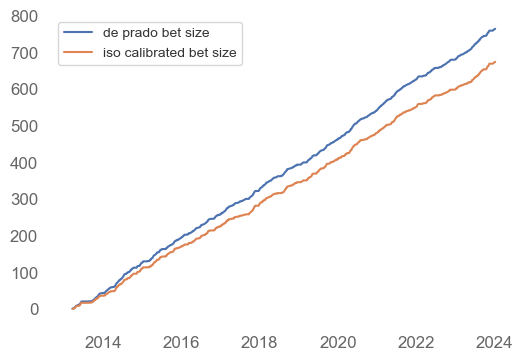

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize = (6, 4))
plt.plot(dp_size.cumsum(), label = 'de prado bet size')
plt.plot(dp_size_iso.cumsum(), label = 'iso calibrated bet size')
plt.legend(fontsize = 10)
plt.grid(False)
plt.show()

#### ECDF

Fit ECDF on training data for prob greater than > 0

In [53]:
ecdf = ECDF(prob_train[prob_train > 0.5])
ecdf_iso = ECDF(prob_isotonic_train[prob_isotonic_train > 0.5])

ECDF Position Sizing on test data

In [54]:
ecdf_size = prob_test.apply(lambda x: ecdf(x) if x > 0.5 else 0)
ecdf_size_iso = prob_isotonic_test.apply(lambda x: ecdf_iso(x) if x > 0.5 else 0)

Daily data update with position sizes

In [55]:
data_test_set['ecdf_size'] = 0
data_test_set['ecdf_size_iso'] = 0
data_test_set.loc[ecdf_size.index, 'ecdf_size'] = ecdf_size
data_test_set.loc[ecdf_size_iso.index, 'ecdf_size_iso'] = ecdf_size_iso

Backtest

In [56]:
data_test_set['ecdf_rets'] = (data_test_set['ecdf_size'] * target_test).shift(1)
data_test_set['ecdf_iso_rets'] = (data_test_set['ecdf_size_iso'] * target_test).shift(1)

#### Sigmoid optimal fit

In [59]:
def target_sigmoid(x):
    # Apply sigmoid position sizing
    f = lambda p: min(max(1 / (1 + np.exp(-x[0] * p - x[1])), 0), 1)
    f = np.vectorize(f)

    # Backtest + sharpe ratio
    rets = f(prob_train[prob_train > 0.5]) * target_train_p[prob_train > 0.5]
    # Solve for no positions taken
    mean, stdev = check_stats(rets)
    # Sharpe Ratio
    sharp_ratio = mean / stdev
    return -sharp_ratio

def target_iso_sigmoid(x):
    # Apply sigmoid position sizing
    f = lambda p: min(max(1 / (1 + np.exp(-x[0] * p - x[1])), 0), 1)
    f = np.vectorize(f)

    # Backtest + sharpe ratio
    rets = f(prob_isotonic_train[prob_isotonic_train > 0.5]) * target_train_p[prob_isotonic_train > 0.5]
    # Solve for no positions taken
    mean, stdev = check_stats(rets)
    # Sharpe Ratio
    sharp_ratio = mean / stdev
    return -sharp_ratio

Train model on training data

In [60]:
x0 = np.array([1, 0])
res = minimize(target_sigmoid, x0, method = 'nelder-mead', options = {'xatol': 1e-8, 'disp': False})
model = res.x

Get size on test

In [61]:
sig_size = 1 / (1 + np.exp(-model[0] * prob_test - model[1]))
sig_size = sig_size[prob_test > 0.5]

Train model on training data

In [62]:
x0 = np.array([1, 0])
res = minimize(target_iso_sigmoid, x0, method = 'nelder-mead', options = {'xatol': 1e-8, 'disp': False})
model = res.x

Get size on test

In [63]:
sig_iso_size = 1 / (1 + np.exp(-model[0] * prob_isotonic_test - model[1]))
sig_iso_size = sig_iso_size[prob_isotonic_test > 0.5]

Assign position sizes

In [64]:
data_test_set['sop_size'] = 0
data_test_set.loc[sig_size.index, 'sop_size'] = sig_size
data_test_set['sop_size_iso'] = 0
data_test_set.loc[sig_iso_size.index, 'sop_size_iso'] = sig_iso_size

Get daily returns

In [65]:
data_test_set['sop_rets'] = (data_test_set['sop_size'] * target_test).shift(1)
data_test_set['sop_rets_iso'] = (data_test_set['sop_size_iso'] * target_test).shift(1)

if (data_test_set['sop_rets_iso'].std() == 0) or (data_test_set['sop_rets_iso'].mean() == 0):
    print('SOP_ISO')
    print(sig_iso_size.mean())
    
if (data_test_set['sop_rets'].std() == 0) or (data_test_set['sop_rets'].mean() == 0):
    print('SOP')
    print(sig_size.mean())

#### Model output size

Normal bet sizing from probabilities

position sizes on test data

In [66]:
model_output = prob_test
model_output_iso = prob_isotonic_test

All or nothing

In [68]:
model_output[model_output >= 0.5] = prob_test
model_output[model_output < 0.5] = 0

model_output_iso[model_output_iso >= 0.5] = prob_isotonic_test
model_output_iso[model_output_iso < 0.5] = 0

Assign position sizes

In [69]:
data_test_set['norm_prob_size'] = 0
data_test_set['norm_prob_iso_size'] = 0
data_test_set.loc[model_output.index, 'norm_prob_size'] = model_output
data_test_set.loc[model_output_iso.index, 'norm_prob_iso_size'] = prob_isotonic_test

Get daily returns

In [70]:
data_test_set['norm_prob_rets'] = (data_test_set['norm_prob_size'] * target_test).shift(1)
data_test_set['norm_prob_iso_rets'] = (data_test_set['norm_prob_iso_size'] * target_test).shift(1)

#### All or nothing

Position sizes on test data

In [71]:
all_or_nothing = prob_test
all_or_nothing_isotonic = prob_isotonic_test

All or nothing

In [72]:
all_or_nothing[all_or_nothing >= 0.5] = 1
all_or_nothing[all_or_nothing < 0.5] = 0
all_or_nothing_isotonic[all_or_nothing_isotonic >= 0.5] = 1
all_or_nothing_isotonic[all_or_nothing_isotonic < 0.5] = 0

Assign position sizes

In [73]:
data_test_set['all_or_nothing_size'] = 0
data_test_set['all_or_nothing_iso_size'] = 0
data_test_set.loc[all_or_nothing.index, 'all_or_nothing_size'] = all_or_nothing
data_test_set.loc[all_or_nothing_isotonic.index, 'all_or_nothing_iso_size'] = all_or_nothing_isotonic

Get daily returns

In [74]:
data_test_set['all_or_nothing_rets'] = (data_test_set['all_or_nothing_size'] * target_test).shift(1)
data_test_set['all_or_nothing_iso_rets'] = (data_test_set['all_or_nothing_iso_size'] * target_test).shift(1)

In [77]:
# data_test_set.fillna(0).to_csv('data_test_set.csv')

#### Statistics

In [78]:
data_test_set = data_test_set.iloc[1:]

In [79]:
test_cumrets = pd.DataFrame(
    {'norm': ((data_test_set['norm_prob_rets'] + 1).cumprod()),
     'norm_iso': ((data_test_set['norm_prob_iso_rets'] + 1).cumprod()),

     'aon': ((data_test_set['all_or_nothing_rets'] + 1).cumprod()),
     'aon_iso': ((data_test_set['all_or_nothing_iso_rets'] + 1).cumprod()),

     'lin': ((data_test_set['lin_rets'] + 1).cumprod()),
     'lin_iso': ((data_test_set['lin_iso_rets'] + 1).cumprod()),

     'lop': ((data_test_set['lop_rets'] + 1).cumprod()),
     'lop_iso': ((data_test_set['lop_iso_rets'] + 1).cumprod()),

     'dp': ((data_test_set['dp_rets'] + 1).cumprod()),
     'dp_iso': ((data_test_set['dp_iso_rets'] + 1).cumprod()),

     'ecdf': ((data_test_set['ecdf_rets'] + 1).cumprod()),
     'ecdf_iso': ((data_test_set['ecdf_iso_rets'] + 1).cumprod()),

     'sop': ((data_test_set['sop_rets'] + 1).cumprod()),
     'sop_iso': ((data_test_set['sop_rets_iso'] + 1).cumprod()),

     'primary': ((data_test_set['prets'] + 1).cumprod()),
     'BAH': ((data_test_set['rets'] + 1).cumprod())}
)

In [80]:
sharpe_ratio = {
    'norm_sr': data_test_set['norm_prob_rets'].mean() / data_test_set['norm_prob_rets'].std() * np.sqrt(252),
    'norm_iso_sr': data_test_set['norm_prob_iso_rets'].mean() / data_test_set['norm_prob_iso_rets'].std() * np.sqrt(252),

    'aon_sr': data_test_set['all_or_nothing_rets'].mean() / data_test_set['all_or_nothing_rets'].std() * np.sqrt(252),
    'aon_iso_sr': data_test_set['all_or_nothing_iso_rets'].mean() / data_test_set['all_or_nothing_iso_rets'].std() * np.sqrt(252),

    'lin_sr': data_test_set['lin_rets'].mean() / data_test_set['lin_rets'].std() * np.sqrt(252),
    'lin_iso_sr': data_test_set['lin_iso_rets'].mean() / data_test_set['lin_iso_rets'].std() * np.sqrt(252),

    'lop_sr': data_test_set['lop_rets'].mean() / data_test_set['lop_rets'].std() * np.sqrt(252),
    'lop_iso_sr': data_test_set['lop_iso_rets'].mean() / data_test_set['lop_iso_rets'].std() * np.sqrt(252),

    'dp_sr': data_test_set['dp_rets'].mean() / data_test_set['dp_rets'].std() * np.sqrt(252),
    'dp_iso_sr': data_test_set['dp_iso_rets'].mean() / data_test_set['dp_iso_rets'].std() * np.sqrt(252),

    'ecdf_sr': data_test_set['ecdf_rets'].mean() / data_test_set['ecdf_rets'].std() * np.sqrt(252),
    'ecdf_iso_sr': data_test_set['ecdf_iso_rets'].mean() / data_test_set['ecdf_iso_rets'].std() * np.sqrt(252),

    'sop_sr': data_test_set['sop_rets'].mean() / data_test_set['sop_rets'].std() * np.sqrt(252),
    'sop_iso_sr': data_test_set['sop_rets_iso'].mean() / data_test_set['sop_rets_iso'].std() * np.sqrt(252),

    'primary_sr': data_test_set['prets'].mean() / data_test_set['prets'].std() * np.sqrt(252),
    'BAH_sr': data_test_set['rets'].mean() / data_test_set['rets'].std() * np.sqrt(252)
}

In [81]:
mean = {
    'norm_avg': (1 + data_test_set['norm_prob_rets'].mean()) ** 252 - 1,
    'norm_iso_avg': (1 + data_test_set['norm_prob_iso_rets'].mean()) ** 252 - 1,

    'aon_avg': (1 + data_test_set['all_or_nothing_rets'].mean()) ** 252 - 1,
    'aon_iso_avg': (1 + data_test_set['all_or_nothing_iso_rets'].mean()) ** 252 - 1,

    'lin_avg': (1 + data_test_set['lin_rets'].mean()) ** 252 - 1,
    'lin_iso_avg': (1 + data_test_set['lin_iso_rets'].mean()) ** 252 - 1,

    'lop_avg': (1 + data_test_set['lop_rets'].mean()) ** 252 - 1,
    'lop_iso_avg': (1 + data_test_set['lop_iso_rets'].mean()) ** 252 - 1,

    'dp_avg': (1 + data_test_set['dp_rets'].mean()) ** 252 - 1,
    'dp_iso_avg': (1 + data_test_set['dp_iso_rets'].mean()) ** 252 - 1,

    'ecdf_avg': (1 + data_test_set['ecdf_rets'].mean()) ** 252 - 1,
    'ecdf_iso_avg': (1 + data_test_set['ecdf_iso_rets'].mean()) ** 252 - 1,

    'sop_avg': (1 + data_test_set['sop_rets'].mean()) ** 252 - 1,
    'sop_iso_avg': (1 + data_test_set['sop_rets_iso'].mean()) ** 252 - 1,

    'primary_avg': (1 + data_test_set['prets'].mean()) ** 252 - 1,
    'BAH_avg': (1 + data_test_set['rets'].mean()) ** 252 - 1
}

In [82]:
standard_deviation = {
    'norm_std': data_test_set['norm_prob_rets'].std() * np.sqrt(252),
    'norm_iso_std': data_test_set['norm_prob_iso_rets'].std() * np.sqrt(252),

    'aon_std': data_test_set['all_or_nothing_rets'].std() * np.sqrt(252),
    'aon_iso_std': data_test_set['all_or_nothing_iso_rets'].std() * np.sqrt(252),

    'lin_std': data_test_set['lin_rets'].std() * np.sqrt(252),
    'lin_iso_std': data_test_set['lin_iso_rets'].std() * np.sqrt(252),

    'lop_std': data_test_set['lop_rets'].std() * np.sqrt(252),
    'lop_iso_std': data_test_set['lop_iso_rets'].std() * np.sqrt(252),

    'dp_std': data_test_set['dp_rets'].std() * np.sqrt(252),
    'dp_iso_std': data_test_set['dp_iso_rets'].std() * np.sqrt(252),

    'ecdf_std': data_test_set['ecdf_rets'].std() * np.sqrt(252),
    'ecdf_iso_std': data_test_set['ecdf_iso_rets'].std() * np.sqrt(252),

    'sop_std': data_test_set['sop_rets'].std() * np.sqrt(252),
    'sop_iso_std': data_test_set['sop_rets_iso'].std() * np.sqrt(252),

    'primary_std': data_test_set['prets'].std() * np.sqrt(252),
    'BAH_std': data_test_set['rets'].std() * np.sqrt(252)
}

Compute MDD

In [83]:
mdds = qs.stats.max_drawdown(test_cumrets)

In [85]:
clean_mdds = {}
for ind, val in mdds.items():
    new_name = ind + '_mdd'

    if val == 0.0:
        val = -(1 - test_cumrets[ind][-1])
        mdds[ind] = val
    clean_mdds[new_name] = val

final = {**sharpe_ratio, **mean, **standard_deviation, **clean_mdds}
final_row = pd.DataFrame(final.values(), index = final.keys()).T

In [87]:
# final_row.to_csv('results.csv')

<Axes: >

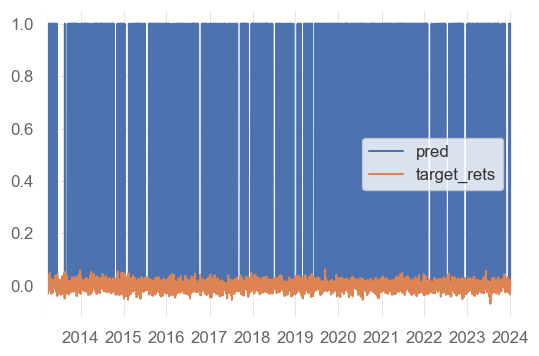

In [91]:
data_test_set[['pred', 'target_rets']].plot(figsize = (6, 4))